<a href="https://colab.research.google.com/github/gsuriano/Project8_Group5/blob/main/Group5_Step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Perparation step

In [ ]:
!pip install nats_bench
!wget "https://www.dropbox.com/sh/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar"
!tar -xf "NATS-tss-v1_0-3ffb9-simple.tar"
print("C")
!pip install xautodl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-06-22 19:21:33--  https://www.dropbox.com/sh/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar [following]
--2022-06-22 19:21:33--  https://www.dropbox.com/sh/raw/ceeo70u1buow681/AADxyCvBAnE6mMjp7JOoo0LVa/NATS-tss-v1_0-3ffb9-simple.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6b75ba621eb926b2241fbcb91e.dl.dropboxusercontent.com/cd/0/inline/BnsMzk4B14677vZzoe1GLbOY4sAckni4uwrVdnIVFBHZjY4AQoCx3RasbJkyflP2l9TWunI0lHIYzR9n9cgzJjx_i_v84h6Hb89apg90Nqq1RcHWO2QQlzNN13gr

In [ ]:
!wget 'https://www.dropbox.com/s/o2fg17ipz57nru1/?dl=1' -O ImageNet16.tar.gz
!tar -xf "ImageNet16.tar.gz"

--2022-06-22 19:24:06--  https://www.dropbox.com/s/o2fg17ipz57nru1/?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/o2fg17ipz57nru1 [following]
--2022-06-22 19:24:06--  https://www.dropbox.com/s/dl/o2fg17ipz57nru1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08602cc7a345f0e1cccfcd503a.dl-eu.dropboxusercontent.com/cd/0/get/BnvUrET1kFZA08QLjQ1DMstjQzHHD7nvBQGNZqyEoyBeYgxcjxkYYb9uczoZ5epRWdtyWdGcrym9Lry6ZScUYPwgvAasL2EFwdjfPDVBkeR-xZ832gqGD1JNDAiyCw3KSS44mF55BN6QHWmqzqD3AX5Kly8byyD6Ten_62Fn01qqnQpYwccI5BgLGlhPXEFuYlU/file?dl=1# [following]
--2022-06-22 19:24:07--  https://uc08602cc7a345f0e1cccfcd503a.dl-eu.dropboxusercontent.com/cd/0/get/BnvUrET1kFZA08QLjQ1DMstjQzHHD7nvBQGNZqyEoyBeYgxcjxkYYb9uczoZ5epRWdtyWdGcry

In [ ]:
!unzip pruners.zip -d .

Archive:  pruners.zip
  inflating: ./pruners/__init__.py   
   creating: ./pruners/measures/
  inflating: ./pruners/measures/__init__.py  
  inflating: ./pruners/measures/fisher.py  
  inflating: ./pruners/measures/grad_norm.py  
  inflating: ./pruners/measures/grasp.py  
  inflating: ./pruners/measures/jacob_cov.py  
  inflating: ./pruners/measures/l2_norm.py  
  inflating: ./pruners/measures/plain.py  
  inflating: ./pruners/measures/snip.py  
  inflating: ./pruners/measures/synflow.py  
  inflating: ./pruners/p_utils.py    
  inflating: ./pruners/predictive.py  


In [ ]:
!tar -xf "models.tar"

In [ ]:
from nats_bench import create
# Create the API instance for the size search space in NATS
api = create("/content/NATS-tss-v1_0-3ffb9-simple/", 'tss', fast_mode=True, verbose=False)

In [ ]:
from models import *
from pruners import *
from pruners import predictive
from pruners.predictive import find_measures

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from xautodl.datasets.DownsampledImageNet import ImageNet16
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

def get_data(dataset,  batch_size, pin_memory=True):
  transform = transforms.Compose([
    transforms.ToTensor() ])
  if dataset == 'cifar10':
    train_data = dset.CIFAR10 ("/content/Cifar10", train=True ,transform = transform, download=True)

  if dataset == 'cifar100':
    train_data = dset.CIFAR100("/content/Cifar100", train=True ,transform = transform, download=True)
    
  if dataset == 'ImageNet16-120':
    train_data = ImageNet16("/content/ImageNet16", True, transform = transform)

  loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin_memory)
  
  return loader


In [ ]:
import numpy as np
import torch
import operator

def getnumclass(dataset):
  return 10 if dataset == 'cifar10' else 100 if dataset == 'cifar100' else 120 

def logdet(K, labels=None):
    s, ld = np.linalg.slogdet(K)
    return ld

def init(m):
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.xavier_normal_(m.weight)

from numba import cuda

@cuda.jit
def constructK(A,C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += operator.xor(bool(A[i, k]),bool(A[j, k]))
        C[i, j] = tmp

In [ ]:
def counting_forward_hook(module, inp, out):
  if isinstance(inp, tuple):
    inp = inp[0]
  inp = inp.view(inp.size(0), -1)
  inp = (inp > 0).float()

  inp = cuda.to_device(inp)
  temp = cuda.device_array((inp.shape[0], inp.shape[0]))

# Configure the blocks
  threadsperblock = (16, 16)
  blockspergrid_x = int(math.ceil(inp.shape[0] / threadsperblock[0]))
  blockspergrid_y = int(math.ceil(inp.shape[1] / threadsperblock[1]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

# Start the kernel 
  constructK[blockspergrid, threadsperblock](inp, temp)

# Copy the result back to the host
  global Ktemp, device
  temp = torch.tensor(temp.copy_to_host()).to(device)
  temp = inp.shape[1]-temp
  Ktemp = Ktemp +  temp

In [ ]:
def control(arch):

  skip = [ node[0] == 'skip_connect' for node in arch]
  
  if sum(skip) == 0:
    return -1
  

In [ ]:
op_names = [
            "none",
            "skip_connect",
            "nor_conv_1x1",
            "nor_conv_3x3",
            "avg_pool_3x3",
]

def list2string(l):
  return f'|{l[0][0][0]}~{l[0][0][1]}|+|{l[1][0][0]}~{l[1][0][1]}|{l[1][1][0]}~{l[1][1][1]}|+|{l[2][0][0]}~{l[2][0][1]}|{l[2][1][0]}~{l[2][1][1]}|{l[2][2][0]}~{l[2][2][1]}|'
  
def mutate(arch_child):
  rand_idx = np.random.randint(0,len(arch_child))
  rand_op = random.choice(op_names)
  arch_child[rand_idx] = (rand_op,arch_child[rand_idx][1])

  if control(arch_child) == -1:
    return -1
  
  str_arch = list2string( [ ( arch_child[0],) , ( arch_child[1] , arch_child[2] ) , ( arch_child[3] , arch_child[4] , arch_child[5] ) ] )
  return api.query_index_by_arch(str_arch)

def generateChild(parent,api):
  arch_parent = api.str2lists(api.get_net_config(int(parent), 'cifar10')['arch_str'])
  arch_child = []
  for i in range(3):
    for j in range(i+1):
      arch_child.append(arch_parent[i][j])

  return mutate(arch_child)

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from scipy import stats
import torch
from copy import deepcopy
import time
import operator
import math
from xautodl.models import get_cell_based_tiny_net
import seaborn 
from matplotlib import pyplot

In [ ]:
def generateChildbyVote(sample,metrics,api):
  op = {"none" : 0,
            "skip_connect" : 0,
            "nor_conv_1x1": 0,
            "nor_conv_3x3" : 0,
            "avg_pool_3x3" : 0}
  sampledata = [ [ api.str2lists(api.get_net_config(i, 'cifar10')['arch_str']) , metrics[i] ] for i in range(len(sample)) ]
  for j in range(len(sample)):
    arch_child = []
    for a in range(3):
      for b in range(a+1):
        arch_child.append(sampledata[j][0][a][b])
    sampledata[j][0] = arch_child

  child = sampledata[1][0]
  for i in range(6):
    op = {"none" : [0,0],
          "skip_connect" : [0,0],
          "nor_conv_1x1": [0,0],
          "nor_conv_3x3" : [0,0],
          "avg_pool_3x3" : [0,0]}
    for j in range(len(sample)):
      op[ sampledata[j][0][i][0] ] [0] += sampledata[j][1]
      op[ sampledata[j][0][i][0] ] [1] += 1
    
    
    for k in op.keys():
      if op[k][1] != 0:
        op[k] = op[k][0]/op[k][1]
      else:
        op[k] = 0

    op_name = max(op, key=op.get)
        
    child[i] = (op_name,child[i][1])
  
  if control(arch_child) == -1:
    return -1
    
  str_arch = list2string( [ ( child[0],) , ( child[1] , child[2] ) , ( child[3] , child[4] , child[5] ) ] )
  
  return api.query_index_by_arch(str_arch)


In [ ]:
def inversion(arch_child):
  rand_idx = sorted(np.random.randint(0,len(arch_child)+1,2))
  ops = [ arch_child[i][0]  for i in range(rand_idx[0],rand_idx[1])]
  idx = 1
  for i in range(rand_idx[0],rand_idx[1]):
    arch_child[i] = (ops[-idx],arch_child[i][1])
    idx = idx + 1

  if control(arch_child) == -1:
    return -1

  str_arch = list2string( [ ( arch_child[0],) , ( arch_child[1] , arch_child[2] ) , ( arch_child[3] , arch_child[4] , arch_child[5] ) ] )
  return api.query_index_by_arch(str_arch)


def generateChildByInversion(parent,api):
  arch_parent = api.str2lists(api.get_net_config(int(parent), 'cifar10')['arch_str'])
  arch_child = []
  for i in range(3):
    for j in range(i+1):
      arch_child.append(arch_parent[i][j])

  return inversion(arch_child)

In [ ]:
def mutateCrossover(parents):
  child = []
  for i in range(6):
    p_idx = np.random.randint(0,2)
    child.append(parents[p_idx][i])
  str_arch = list2string( [ (child[0] ,) , ( child[1] , child[2] ) , ( child[3] , child[4] , child[5] ) ] )
  del child
  return api.query_index_by_arch(str_arch)


def generateChildByCrossover(parents,api):
  
  arch_parent0 = api.str2lists(api.query_info_str_by_arch( int(parents[0]) ).split("\n")[0] )
  arch_parent1 = api.str2lists(api.query_info_str_by_arch( int(parents[1]) ).split("\n")[0] )
  parent0 = []
  parent1 = []
  for i in range(3):
      for j in range(i+1):
        parent0.append(arch_parent0[i][j])
        parent1.append(arch_parent1[i][j])

  del arch_parent0, arch_parent1
  return mutateCrossover([parent0,parent1])


#Rea with synflow

In [ ]:
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  if control(arch) == -1:
    return -1
  
  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  syn = find_measures(network,train_loader,('random',1,getnumclass(dataset)),device,measure_names=['synflow'])['synflow']

  csv_dict = {'Dataset': dataset, 'Network': net, 'Metric': 0, 'Relu' : counter, 'synflow' : np.log(syn), 'mode': mode}
  result = pd.DataFrame([csv_dict])
  strfile = f"/content/out_{dataset}_{run}.csv"
  result.to_csv(strfile, mode='a', index=False, header=False )

  return np.log(syn)
  

In [ ]:
datasetNames =['ImageNet16-120']
#['cifar10','cifar100','ImageNet16-120']

batch_size = 128
runs_rea = 10
population_size = 50
cicles = 200
sample_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
counter = 0

for dataset in datasetNames:

  train_loader = get_data(dataset, batch_size)

  for run in range(runs_rea):
    
    start = time.time()
    relumax = 0
    population =  np.random.randint(0,len(api),population_size)
    history = population

    metricspop = np.array([ get_score(dataset,net,api,train_loader,run,'random') for net in population ])

    good_idx = (metricspop != -1)

    population = population[good_idx]
    metricspop = metricspop[good_idx]
    history = history[good_idx]
    
    i= 0
    while(len(history) < cicles):

      sample_idx = np.random.randint(0,len(population),sample_size)

      sample = population[sample_idx]

      metrics = metricspop[sample_idx]

      parent = sample[np.argmax(metrics)]

      child = generateChild(parent,api)
      
      if child not in history:
        if child != -1:
          scorechild = get_score(dataset,child,api,train_loader,run,'child')
          if scorechild != -1:
            population[:-1] = population[1:]
            metricspop[:-1] = metricspop[1:]
            population[-1] = child
            metricspop[-1] = scorechild
            history = np.append(history,child)
      i = i+1

    strfile = f"/content/out_{dataset}_{run}.csv"
    csv_df = pd.read_csv(strfile,names = ['Dataset','Network','Metric','Relu','syn','mode'], header = None, index_col=['Dataset'])

    tempo = time.time()-start

    best = csv_df.nlargest(1,'syn')
    acc = api.get_more_info(int(best['Network']),dataset,is_random=False,hp=200)['test-accuracy']
 
    csv_dict = {'Dataset': dataset, 'Network': best['Network'].values[0], 'Metric': best['Metric'].values[0], 'syn': best['syn'].values[0], 'Accuracy': acc, 'Time':tempo, 'mode' : best['mode'].values[0]}
    result = pd.DataFrame([csv_dict])
    result.to_csv('rea_synflow.csv', mode='a', index=False, header=False )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


In [ ]:
df = pd.read_csv("/content/rea_synflow.csv",names = ['Dataset','Network','Metric','syn','Accuracy','Time','mode'], header = None, index_col=['Dataset','Network'])

metric = df.groupby(by = 'Dataset')['syn'].describe()[['mean','std']]
accuracy = df.groupby(by = 'Dataset')['Accuracy'].describe()[['mean','std']]
time = df.groupby(by = 'Dataset')['Time'].describe()[['mean','std']]

data = pd.concat([metric,accuracy,time],axis=1)
data.to_csv('stats_rea_synflow.csv')

#Rea with naswot score

In [ ]:
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  if control(arch) == -1:
    return -1

  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  counter = 0

  for name, module in network.named_modules():
    if (isinstance(module, torch.nn.modules.activation.ReLU)):
      counter +=1
      module.register_forward_hook(counting_forward_hook)

  network = network.to(device)

  global Ktemp
  Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
  data_iterator = iter(train_loader)
  x, target = next(data_iterator)
  x, target = x.to(device), target.to(device)
  network(x)
  score = logdet(Ktemp.cpu().detach().numpy(), target)
  
  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  syn = 0

  csv_dict = {'Dataset': dataset, 'Network': net, 'Metric': score, 'Relu' : counter, 'synflow' : np.log(syn), 'mode': mode}
  result = pd.DataFrame([csv_dict])
  strfile = f"out_{dataset}_{run}.csv"
  result.to_csv(strfile, mode='a', index=False, header=False )

  return score
  

In [ ]:
datasetNames =['cifar10','cifar100','ImageNet16-120']

batch_size = 128
runs_rea = 10
population_size = 50
cicles = 200
sample_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
counter = 0

for dataset in datasetNames:

  train_loader = get_data(dataset, batch_size)

  for run in range(runs_rea):
    
    start = time.time()
    relumax = 0
    seed = np.random.randint(0,15000)
    np.random.seed(run)
    population =  np.random.randint(0,len(api),population_size)
    history = population

    metricspop = np.array([ get_score(dataset,net,api,train_loader,run,'random') for net in population ])

    good_idx = (metricspop != -1)

    population = population[good_idx]
    metricspop = metricspop[good_idx]
    history = history[good_idx]
    
    i= 0
    while(len(history) < cicles):

      sample_idx = np.random.randint(0,len(population),sample_size)

      sample = population[sample_idx]

      metrics = metricspop[sample_idx]

      parent = sample[np.argmax(metrics)]

      child = generateChild(parent,api)
      
      if child not in history:
        if child != -1:
          scorechild = get_score(dataset,child,api,train_loader,run,'child')
          if scorechild != -1:
            population[:-1] = population[1:]
            metricspop[:-1] = metricspop[1:]
            population[-1] = child
            metricspop[-1] = scorechild
            history = np.append(history,child)
      i = i+1

    strfile = f"/content/out_{dataset}_{run}.csv"
    csv_df = pd.read_csv(strfile,names = ['Dataset','Network','Metric','Relu','syn','mode'], header = None, index_col=['Dataset'])

    tempo = time.time()-start

    best = csv_df.nlargest(1,'Metric')
    acc = api.get_more_info(int(best['Network']),dataset,is_random=False,hp=200)['test-accuracy']
 
    csv_dict = {'Dataset': dataset, 'Network': best['Network'].values[0], 'Metric': best['Metric'].values[0], 'syn': best['syn'].values[0], 'Accuracy': acc, 'Time':tempo, 'mode' : best['mode'].values[0]}
    result = pd.DataFrame([csv_dict])
    result.to_csv('rea_naswot.csv', mode='a', index=False, header=False )

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


Files already downloaded and verified


In [ ]:
df = pd.read_csv("/content/rea_naswot.csv",names = ['Dataset','Network','Metric','syn','Accuracy','Time','mode'], header = None, index_col=['Dataset','Network'])

metric = df.groupby(by = 'Dataset')['Metric'].describe()[['mean','std']]
accuracy = df.groupby(by = 'Dataset')['Accuracy'].describe()[['mean','std']]
time = df.groupby(by = 'Dataset')['Time'].describe()[['mean','std']]

data = pd.concat([metric,accuracy,time],axis=1)
data.to_csv('stats_rea_naswot.csv')

#Rea different ways to generate child

In [ ]:
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  if control(arch) == -1:
    return -1
  
  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  syn = find_measures(network,train_loader,('random',1,getnumclass(dataset)),device,measure_names=['synflow'])['synflow']

  csv_dict = {'Dataset': dataset, 'Network': net, 'Metric': 0, 'Relu' : counter, 'synflow' : np.log(syn), 'mode': mode}
  result = pd.DataFrame([csv_dict])
  strfile = f"/content/gentest_{dataset}.csv"
  result.to_csv(strfile, mode='a', index=False, header=False )

  return np.log(syn)
  

In [ ]:
datasetNames = ['ImageNet16-120']

#['cifar10','cifar100','ImageNet16-120']

batch_size = 128
runs_rea = 1
population_size = 50
cicles = 300
sample_size = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Ktemp = torch.tensor(np.zeros((batch_size,batch_size))).to(device)
counter = 0

for dataset in datasetNames:

  train_loader = get_data(dataset, batch_size)

  for run in range(runs_rea):
    
    start = time.time()
    relumax = 0
    population =  np.random.randint(0,len(api),population_size)
    history = population

    metricspop = np.array([ get_score(dataset,net,api,train_loader,run,'random') for net in population ])

    good_idx = (metricspop != -1)

    population = population[good_idx]
    metricspop = metricspop[good_idx]
    history = history[good_idx]
    
    i= 0
    while(len(history) < cicles):

      sample_idx = np.random.randint(0,len(population),sample_size)

      sample = population[sample_idx]

      metrics = metricspop[sample_idx]

      mode = ''

      if i % 4 <= 1:
        parent = sample[np.argmax(metrics)]

        if i % 4 == 0:
          child = generateChild(parent,api)
          mode = 'mutation'
        if i % 4 == 1:
          child = generateChildByInversion(parent,api)
          mode = 'inversion'
      
      if i % 4 == 2:
        child = generateChildbyVote(sample,metrics,api)
        mode = 'majority vote'
      
      if i % 4 == 3:
        mask = np.argsort(metrics)[[0,-1]]
        parents = sample[mask]
        child = generateChildByCrossover(parents,api)
        mode = 'crossover'
        
      if child not in history:
        if child != -1:
          scorechild = get_score(dataset,child,api,train_loader,run,mode)
          if scorechild != -1:
            population[:-1] = population[1:]
            metricspop[:-1] = metricspop[1:]
            population[-1] = child
            metricspop[-1] = scorechild
            history = np.append(history,child)
      i = i+1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


In [ ]:
dataset = 'cifar100'
strfile = f"/content/gentest_{dataset}.csv"
csv_df = pd.read_csv(strfile,names = ['Dataset','Network','Metric','Relu','syn','mode'], header = None, index_col=['Dataset'])
csv_df['accuracy'] = [ api.get_more_info(int(i),'ImageNet16-120',hp=200,is_random=False)['test-accuracy'] for i in csv_df['Network'].values]

No handles with labels found to put in legend.


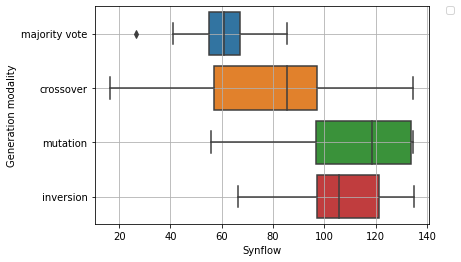

In [ ]:
import matplotlib.pyplot as plt
seaborn.boxplot(data=csv_df.iloc[220:300],x="syn", y ="mode")
plt.grid()
pyplot.legend(bbox_to_anchor=(1.05,1),loc = 2, borderaxespad=0.)
pyplot.xlabel('Synflow')
pyplot.ylabel('Generation modality')
pyplot.savefig('gen.pdf',dpi=300,bbox_inches='tight')

#Random search with synflow

In [ ]:
def get_score(dataset,net,api,train_loader,run,mode):

  arch_tuple = api.str2lists(api.get_net_config(int(net), 'cifar10')['arch_str'])
  arch= []
  for i in range(3):
    for j in range(i+1):
      arch.append(arch_tuple[i][j])
  
  if control(arch) == -1:
    return -1
  
  config = api.get_net_config(net, dataset)
  network = get_cell_based_tiny_net(config)
  network.apply(init)

  syn = find_measures(network,train_loader,('random',1,getnumclass(dataset)),device,measure_names=['synflow'])['synflow']

  csv_dict = {'Dataset': dataset, 'Network': net, 'Metric': 0, 'Relu' : counter, 'synflow' : np.log(syn), 'mode': mode}
  result = pd.DataFrame([csv_dict])
  strfile = f"/content/random_{dataset}_{run}.csv"
  result.to_csv(strfile, mode='a', index=False, header=False )

  return np.log(syn)
  

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from scipy import stats
import torch
import time
import operator
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datasetNames = ['ImageNet16-120']#['cifar10','cifar100','ImageNet16-120']

runs = 10
sample_size = 200
batch_size = 128

for dataset in datasetNames:  
  for run in range(runs):

    train_loader = get_data(dataset, batch_size)
    scores = []
    nets = np.random.randint(0,len(api),size=sample_size)
    counter = 0

    start = time.time()

    for i in nets:
      scores.append(get_score(dataset,int(i),api,train_loader,run,'child'))

    ind_best = np.argmax(scores)
    acc = api.get_more_info(int(nets[ind_best]),dataset,is_random=False,hp=200)['test-accuracy']
    tempo = time.time()-start
    csv_dict = {'Dataset': dataset, 'Network': nets[ind_best], 'Metric': scores[ind_best], 'Accuracy': acc, 'Time': tempo}
    result = pd.DataFrame([csv_dict])
    result.to_csv('random_syn.csv', mode='a', index=False, header=False )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


In [ ]:
dataset

'cifaar100'

#None tests

In [ ]:
api.get_net_config(6118,'cifar10')

{'C': 16,
 'N': 5,
 'arch_str': '|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|',
 'name': 'infer.tiny',
 'num_classes': 10}

In [ ]:
for i in range(12096,len(api)):
  arch_str = api.get_net_config(i,'cifar10')['arch_str']
  if 'none' in arch_str:
    csv_dict = {'i' : i, 'accuracy' : api.get_more_info(int(i),'cifar10',hp=200,is_random = False)['test-accuracy']}
    result = pd.DataFrame([csv_dict])
    result.to_csv('none.csv', mode='a', index=False, header=False )

In [ ]:
none = pd.read_csv("/content/none.csv",names = ['Network','accuracy'],header = None, index_col=['Network'])

for i in none.index.to_numpy()[8695:]:
  arch_tup = api.str2lists(api.get_net_config(i, 'cifar10')['arch_str'])
  arch = []
  for h in range(3):
    for j in range(h+1):
      arch.append(arch_tup[h][j])
  csv_dict = {'i' : i, 'accuracy' : none.loc[i]['accuracy'], '0':1 if arch[0][0] == 'none' else 0, '1':1 if arch[1][0] == 'none' else 0,'2':1 if arch[2][0] == 'none' else 0,'3':1 if arch[3][0] == 'none' else 0,'4':1 if arch[4][0] == 'none' else 0,'5':1 if arch[5][0] == 'none' else 0}
  result = pd.DataFrame([csv_dict])
  result.to_csv('no.csv', mode='a', index=False, header=False )
    

In [ ]:
none = pd.read_csv("/content/no.csv",names = ['Network','accuracy','0','1','2','3','4','5'],header = None, index_col=['Network'])


In [ ]:
none.nlargest(500,'accuracy')[['0','1','2','3','4','5']].describe()

,0,1,2,3,4,5
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.134000,0.278000,0.322000,0.086000,0.272000,0.124000
std,0.340993,0.448462,0.467711,0.280645,0.445436,0.329912
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
none.nsmallest(500,'accuracy')[['0','1','2','3','4','5']].describe()

,0,1,2,3,4,5
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,0.476000,0.406000,0.24600,0.824000,0.400000,0.476000
std,0.499924,0.491576,0.43111,0.381202,0.490389,0.499924
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [ ]:
none['count'] = none[['0','1','2','3','4','5']].sum(axis=1)

In [ ]:
none.groupby('count').describe()

accuracy                                                               \
         count       mean        std    min        25%        50%       75%   
count                                                                         
1       6144.0  89.424538   5.697291  52.47  88.945000  91.195833  92.30000   
2       3840.0  87.914883   5.721126  62.79  86.660000  89.675833  91.91500   
3       1280.0  74.630120  27.786991  10.00  75.759167  86.700000  90.70750   
4        240.0  45.324278  38.087885  10.00  10.000000  10.000000  86.69625   
5         24.0  22.627431  28.960819  10.00  10.000000  10.000000  10.00000   
6          1.0  10.000000        NaN  10.00  10.000000  10.000000  10.00000   

                       0            ...    4            5                      \
             max   count      mean  ...  75%  max   count      mean       std   
count                               ...                                         
1      94.240000  6144.0  0.166667  ...  0.0  1.0  6144.0  0.166667  0.372708   
2      94.045000  3840.0  0.333333  ...  1.0  1.0  3840.0  0.333333  0.471466   
3      93.706667  1280.0  0.500000  ...  1.0  1.0  1280.0  0.500000  0.500195   
4      92.275000   240.0  0.666667  ...  1.0  1.0   240.0  0.666667  0.472390   
5      92.290000    24.0  0.833333  ...  1.0  1.0    24.0  0.833333  0.380693   
6      10.000000     1.0  1.000000  ...  1.0  1.0     1.0  1.000000       NaN   

                                
       min  25%  50%  75%  max  
count                           
1      0.0  0.0  0.0  0.0  1.0  
2      0.0  0.0  0.0  1.0  1.0  
3      0.0  0.0  0.5  1.0  1.0  
4      0.0  0.0  1.0  1.0  1.0  
5      0.0  1.0  1.0  1.0  1.0  
6      1.0  1.0  1.0  1.0  1.0  

[6 rows x 56 columns]

# Baseline : REA

In [ ]:
datasetNames = ['cifar10','cifar100','ImageNet16-120']

runs_rea = 30
population_size = 60 
cicles = 60
sample_size = 10

csv_df = pd.read_csv("/content/out.csv",names = ['Dataset','Network','Metric','Accuracy','Time'], header = None, index_col=['Dataset','Network'])

for dataset in datasetNames:

  for run in range(runs_rea):
    
    start = time.time()
    population =  np.random.randint(0,len(api),population_size)
    history = population

    for i in range(cicles):

      sample_idx = np.random.randint(0,len(population),sample_size)

      sample = population[sample_idx]

      metrics = [ csv_df.loc[dataset,sample[j]]['Metric'] for j in range(len(sample)) ]

      parent_idx = np.argmax(metrics)

      parent = sample[parent_idx]

      child = generateChild(parent,api)

      population[:-1] = population[1:]
      population[-1] = child
      history = np.append(history,child)


    scores = []
    tempo = 0

    for i in history:
      scores.append(csv_df.loc[dataset,i]['Metric'])
      tempo += csv_df.loc[dataset,i]['Time']


    ind_best = np.argmax(scores)
    acc = api.get_more_info(int(history[ind_best]),dataset,is_random=False,hp=200)['test-accuracy']
    tempo += time.time()-start
    csv_dict = {'Dataset': dataset, 'Network': history[ind_best], 'Metric': scores[ind_best], 'Accuracy': acc, 'Time':tempo}
    result = pd.DataFrame([csv_dict])
    result.to_csv('rea.csv', mode='a', index=False, header=False )

#stats

In [ ]:
import pandas as pd
rea = pd.read_csv("/content/rea.csv",names = ['Dataset','Network','Metric','Accuracy','Time'], header = None, index_col=['Dataset','Network'])
rea_stats = rea.groupby('Dataset')['Accuracy','Time'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
rea_stats

Accuracy                                                    \
                  count       mean       std        min       25%     50%   
Dataset                                                                     
ImageNet16-120     30.0  42.801111  3.534741  35.477778  42.40000  43.875   
cifar10            30.0  92.877944  1.256439  89.050000  93.01625  93.320   
cifar100           30.0  69.984444  1.101478  65.706667  69.62250  69.880   

                                      Time                                     \
                      75%        max count        mean        std         min   
Dataset                                                                         
ImageNet16-120  45.304167  45.983333  30.0  115.236726   6.200568  104.532023   
cifar10         93.436250  93.666667  30.0  305.804567  17.001866  259.119469   
cifar100        70.782500  71.740000  30.0  306.723708  14.760363  274.507115   

                                                                
                       25%         50%         75%         max  
Dataset                                                         
ImageNet16-120  110.399227  115.828789  118.292396  130.705759  
cifar10         296.831497  308.022109  314.286655  335.367882  
cifar100        297.625801  306.065329  317.654886  335.120182

In [ ]:
our_stats
# meglio senza invesione, questo solo majority vote con 60 - 50 - ogni 10

Accuracy                                                        \
                  count       mean       std        min        25%        50%   
Dataset                                                                         
ImageNet16-120     30.0  44.225741  2.551034  35.477778  43.952778  44.916667   
cifar10            30.0  92.799778  1.410962  89.370000  92.793333  93.335000   
cifar100           30.0  70.082000  1.464949  64.570000  69.617500  70.270000   

                                      Time                                     \
                      75%        max count        mean        std         min   
Dataset                                                                         
ImageNet16-120  45.577778  46.550000  30.0  115.692814   8.196630  105.679032   
cifar10         93.547500  93.983333  30.0  306.259962  17.361746  276.786297   
cifar100        71.242500  71.740000  30.0  303.329580  16.697490  270.196257   

                                                                
                       25%         50%         75%         max  
Dataset                                                         
ImageNet16-120  110.642108  114.815559  117.480347  140.183601  
cifar10         295.161826  302.665780  317.609872  353.980955  
cifar100        291.457133  298.906640  313.889436  341.252009

In [ ]:
our_stats
#migliore con entrambi usando 50 - 50 cicli - ogni 7


Accuracy                                                        \
                  count       mean       std        min        25%        50%   
Dataset                                                                         
ImageNet16-120     90.0  43.185556  3.375219  34.016667  42.120833  44.633333   
cifar10            90.0  92.935130  1.144397  88.570000  92.957500  93.315000   
cifar100           90.0  70.084704  1.153559  65.706667  69.613333  70.200000   

                                      Time                                     \
                      75%        max count        mean        std         min   
Dataset                                                                         
ImageNet16-120  45.616667  46.550000  90.0  113.050130  10.100397   92.431673   
cifar10         93.535833  93.893333  90.0  296.344541  25.244924  245.969126   
cifar100        70.860000  71.740000  90.0  295.949536  22.755679  249.234018   

                                                                
                       25%         50%         75%         max  
Dataset                                                         
ImageNet16-120  104.831791  112.609008  119.594778  144.263894  
cifar10         275.460850  296.851407  314.856265  362.855431  
cifar100        280.955291  296.492350  310.170904  340.236372

In [ ]:
import pandas as pd
rea = pd.read_csv("/content/rea2.csv",names = ['Dataset','Network','Metric','Accuracy','Time'], header = None, index_col=['Dataset','Network'])
our_stats = rea.groupby('Dataset')['Accuracy','Time'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
rea = pd.read_csv("/content/out.csv",names = ['Dataset','Network','Metric','Accuracy','Time'], header = None, index_col=['Dataset','Network'])
stats = rea.groupby('Dataset')['Metric','Time'].describe()

In [ ]:
import numpy as np
accuracies = np.zeros(len(api))
for i in range(len(api)):
   acc =api.get_more_info(i,'cifar10')['test-accuracy']
   accuracies[i] = acc
   del acc



csv_df.groupby('Dataset')['Accuracy'].describe()['max']

KeyboardInterrupt: ignored

In [ ]:
api.get_cost_info(12, 'cifar10')

{'T-ori-test@epoch': 1.0880018813269479,
 'T-ori-test@total': 13.056022575923373,
 'T-train@epoch': 13.317416548728943,
 'T-train@total': 159.80899858474731,
 'flops': 43.17249,
 'latency': 0.012879044340367903,
 'params': 0.316346}

# Our REA

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from scipy import stats
import torch
import time
import operator
import math

op_names = [
            "none",
            "skip_connect",
            "nor_conv_1x1",
            "nor_conv_3x3",
            "avg_pool_3x3",
]

def mutateCrossover(parents):
  child = []
  for i in range(6):
    p_idx = np.random.randint(0,2)
    child.append(parents[p_idx][i])
  str_arch = list2string( [ (child[0] ,) , ( child[1] , child[2] ) , ( child[3] , child[4] , child[5] ) ] )
  del child
  return api.query_index_by_arch(str_arch)


def generateChildByCrossover(parents,api):
  
  arch_parent0 = api.str2lists(api.query_info_str_by_arch( int(parents[0]) ).split("\n")[0] )
  arch_parent1 = api.str2lists(api.query_info_str_by_arch( int(parents[1]) ).split("\n")[0] )
  parent0 = []
  parent1 = []
  for i in range(3):
      for j in range(i+1):
        parent0.append(arch_parent0[i][j])
        parent1.append(arch_parent1[i][j])

  del arch_parent0, arch_parent1
  return mutateCrossover([parent0,parent1])

datasetNames = ['cifar10','cifar100','ImageNet16-120']

runs_rea = 1
population_size = 20 
cicles = 45   

csv_df = pd.read_csv("/content/out.csv",names = ['Dataset','Network','Metric','Accuracy','Time'], header = None, index_col=['Dataset','Network'])

for dataset in datasetNames:  

  for run in range(runs_rea):
    
    start = time.time()
    population =  np.random.randint(0,len(api),population_size)
    history = population

    for i in range(cicles):
      
      metrics = [ csv_df.loc[dataset,population[j]]['Metric'] for j in range(len(population)) ]
      
      parents = population[np.argsort(metrics) < 2]
      #aggiungere metrica

      child0 = generateChild(parents[np.random.randint(0,2)],api)

      child1 = generateChildByCrossover(parents,api)

      population = np.delete (population,np.argmin(metrics))
      metrics = [ csv_df.loc[dataset,population[j]]['Metric'] for j in range(len(population)) ]
      population = np.delete (population,np.argmin(metrics))
      population = np.append(population,child0)
      population = np.append(population,child1)
      history = np.append(history,child0)
      history = np.append(history,child1)
      

    scores = []

    tempo = 0
    for i in history:
      scores.append(csv_df.loc[dataset,i]['Metric'])
      tempo += csv_df.loc[dataset,i]['Time']

    tempo += time.time()-start

    ind_best = np.argmax(scores)
    acc = api.get_more_info(int(history[ind_best]),dataset,is_random=False,hp=200)['test-accuracy']
    csv_dict = {'Dataset': dataset, 'Network': history[ind_best], 'Metric': scores[ind_best], 'Accuracy': acc, 'Time' : tempo}
    result = pd.DataFrame([csv_dict])
    print(len(history))

#genera network da majority vote in history per somma di score e valutazione

    #del csv_dict, scores,history
    result.to_csv('our_rea.csv', mode='a', index=False, header=False )

    

110
110
110


# Plot

In [ ]:
import pandas as pd

out = pd.read_csv('/content/out.csv', names = ['Dataset','Network','Metric','Accuracy','Time'], header = None)

In [ ]:
c10 =  out[out['Dataset'] == 'cifar10']
c100 =  out[out['Dataset'] == 'cifar100']
inet =  out[out['Dataset'] == 'ImageNet16-120']

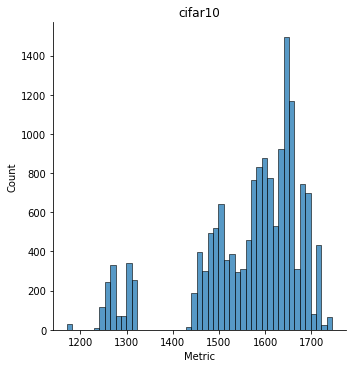

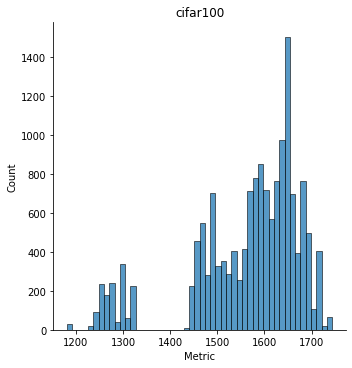

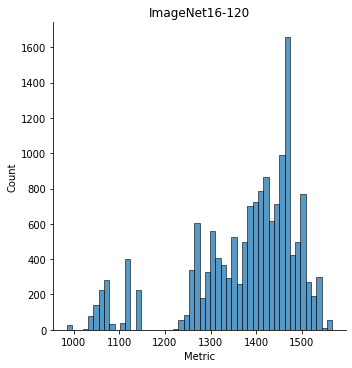

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.displot(data=c10, x='Metric').set(title='cifar10')
sns.displot(data=c100, x='Metric').set(title='cifar100')
sns.displot(data=inet, x='Metric').set(title='ImageNet16-120')